In [1]:
import edward as ed
import numpy as np
import tensorflow as tf

import seaborn as sns
from matplotlib import pyplot as plt

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
sess = tf.InteractiveSession()

In [3]:
floatX = 'float32'
np.random.seed(1234)
N = 10

X = np.random.normal(size=[N,3]).astype(floatX)
X[:,0] = (X[:,0] - 0.2*X[:,1])/2
X[:,-1] = 1
ystd = 0.5

y_obs = 2*X[:,0] + X[:,1] + 3 + np.random.normal(size=N)*ystd

In [4]:
gibbs = True

In [5]:
T = 100000
if not gibbs:
    c_q = ed.models.Empirical(tf.Variable(np.zeros([T, 3], dtype=floatX), name='coefs_trace'))
else:
    c0_q = ed.models.Empirical(tf.Variable(np.zeros([T, 1], dtype=floatX), name='c0_trace'))
    c1_q = ed.models.Empirical(tf.Variable(np.zeros([T, 2], dtype=floatX), name='c1_trace'))

    extr = lambda *x: list(map(lambda x: x.get_variables()[0], x))
    c_q = ed.models.Empirical(tf.concat(extr(c0_q, c1_q), axis=-1))

    c0v, c1v = extr(c0_q, c1_q)

In [6]:
if not gibbs:
    coefs = ed.models.Normal(loc=[0.,0.,0], scale=5.)
else:
    c0i = tf.placeholder_with_default(False, shape=())
    c1i = tf.placeholder_with_default(False, shape=())

    t = tf.Variable(0)
    c0p = tf.gather(c0v, t)
    c1p = tf.gather(c1v, tf.maximum(0, t-1))

    c0 = ed.models.Normal(loc=[0.], scale=5.)
    c0_ = tf.where(c0i, c0, c0p)

    c1 = ed.models.Normal(loc=[0.,0.], scale=5.)
    c1_ = tf.where(c1i, c1, c1p)

    coefs = tf.concat([c0_,c1_], axis=0)
    upd_op = tf.assign_add(t, 1)

y = ed.models.Normal(loc=tf.matmul(X, coefs[:,tf.newaxis])[:,0],scale=ystd)

In [7]:
if not gibbs:
    ic = ed.HMC({coefs: c_q}, data={y:y_obs})
    ic.initialize(step_size=1e-1)

else:
    ic0 = ed.HMC({c0: c0_q}, data={y:y_obs})
    ic1 = ed.HMC({c1: c1_q}, data={y:y_obs})
    ic0.initialize(step_size=1e-1)
    ic1.initialize(step_size=1e-1)

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


In [8]:
tf.global_variables_initializer().run()

In [9]:
if not gibbs:
    for i in range(ic.n_iter):
        res = ic.update()
        ic.print_progress(res)
else:
    for i in range(ic0.n_iter):
        res = ic0.update({c0i:True})
        ic1.update({c1i:True})
        sess.run(upd_op)
        ic0.print_progress(res)

100000/100000 [100%] ██████████████████████████████ Elapsed: 198s | Acceptance Rate: 0.989


In [10]:
samples = []
for _ in range(2000):
    s = sess.run(c_q)
    samples.append(s)
samples = np.array(samples)

### Gibbs:

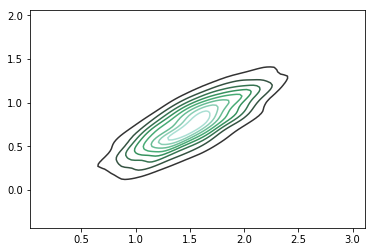

In [11]:
sns.kdeplot(samples[:,0], samples[:,1])
plt.show()

In [12]:
np.mean(samples, axis=0)

array([1.5231783, 0.7631635, 3.1867404], dtype=float32)

In [13]:
np.corrcoef(samples.T)

array([[1.        , 0.79333887, 0.4551108 ],
       [0.79333887, 1.        , 0.62493973],
       [0.4551108 , 0.62493973, 1.        ]])

### Direct HMC:

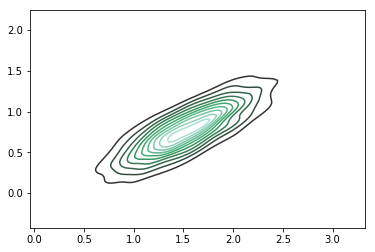

In [11]:
sns.kdeplot(samples[:,0], samples[:,1])
plt.show()

In [12]:
np.mean(samples, axis=0)

array([1.5340663, 0.7705427, 3.1870906], dtype=float32)

In [13]:
np.corrcoef(samples.T)

array([[1.        , 0.80268639, 0.49245838],
       [0.80268639, 1.        , 0.64094183],
       [0.49245838, 0.64094183, 1.        ]])